In [1]:
import sys
sys.path.append('../gym_art')

from PIL import Image

from paintings import PaintingEnv
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple, deque

from tqdm import tqdm
import plotnine as pn

What is our output

In [3]:
env = PaintingEnv()

## Factors

There are two main factors here. Artist (gallery) and painting type (concrete, intermediate, abstract).

In [22]:
artists = list(env.artist_to_val.keys())
ptypes = ['concrete', 'intermediate', 'abstract']

print(artists)
print(ptypes)

['Rot', 'Cli', 'Mon']
['concrete', 'intermediate', 'abstract']


## What We Have Now

In [17]:
state, reward, done, info = env.reset(full_reset=False) # reset environment

In [18]:
next_state, reward, done, info2 = env.step(0)

In [19]:
info

{'left': {'name': 'Clib1n',
  'type': 'concrete',
  'train': True,
  'style': 'Cli',
  'phase': 1,
  'value': 0,
  'path': '/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/gym_art/stimuli/Clib1n.jpeg',
  'display_value': 20},
 'right': {'name': 'Clia2n',
  'type': 'intermediate',
  'train': True,
  'style': 'Cli',
  'phase': 1,
  'value': 0,
  'path': '/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/gym_art/stimuli/Clia2n.jpeg',
  'display_value': 20},
 'trial_type': 'same artist'}

## Creating New States

We want to make a new state based on the artist and painting type. This will be a tuple for the left and right painting. Each painting will have 6 values. 3 values for the artist and 3 values for the painting type (one hot encoding).

In [43]:
info

{'left': {'name': 'Clib1n',
  'type': 'concrete',
  'train': True,
  'style': 'Cli',
  'phase': 1,
  'value': 0,
  'path': '/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/gym_art/stimuli/Clib1n.jpeg',
  'display_value': 20},
 'right': {'name': 'Clia2n',
  'type': 'intermediate',
  'train': True,
  'style': 'Cli',
  'phase': 1,
  'value': 0,
  'path': '/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/gym_art/stimuli/Clia2n.jpeg',
  'display_value': 20},
 'trial_type': 'same artist'}

In [47]:
trial_info = [ [sinfo['style'],sinfo['type']] for side,sinfo in info.items() if side in ['left','right'] ]
trial_info

[['Cli', 'concrete'], ['Cli', 'intermediate']]

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
enc = OneHotEncoder(categories=[np.array(artists), np.array(ptypes)])

In [49]:
enc.fit_transform(trial_info).toarray()

array([[0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0.]])

In [53]:
enc.fit_transform(trial_info).toarray().flatten()

array([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])

## Make to a Function

In [54]:
def get_direct_state(info):
    trial_info = [ [sinfo['style'],sinfo['type']] for side,sinfo in info.items() if side in ['left','right'] ]
    state = enc.fit_transform(trial_info).toarray().flatten()
    return state

# Run It

## Original Model

This is the model where the two left and right painting are concatenated together.

In [58]:
import agent
#from importlib import reload
#agent = reload(agent)
Agent = agent.Agent

In [61]:
def dqn(agent, n_episodes=100, eps_start=1.0, eps_end=0.1, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): The agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
    """
    scores = []                        # list containing scores from each episode
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, reward, done, info = env.reset(full_reset=False) # reset environment
        score = 0
        for t in range(env.n_trials - 1):
            pp_state = get_direct_state(info)
            action = agent.act(pp_state, eps)                   # select an action
            next_state, reward, done, info = env.step(action)   # send action to environment
            pp_next_state = get_direct_state(info)
            agent.step(pp_state, action, reward, pp_next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break
        mean_score = score/t # keep scores in range of 0-1, allow comparison to humans above
        scores.append(mean_score)                 # save most recent score to total
        moving_avg = np.mean(scores)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
    return scores, moving_avgs

In [84]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 16, 
    'gamma': 0, # no gamma
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-4, 
    'fc1_units': 64, 
    'fc2_units': 32, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5, 
    'use_next_Q': True
}
agent = Agent(state_size=6*2, action_size=2, config_dict=config_dict)
scores1, _ = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.40
Episode 10	Average Score: 0.42
Episode 15	Average Score: 0.42
Episode 20	Average Score: 0.43
Episode 25	Average Score: 0.43
Episode 30	Average Score: 0.44
Episode 35	Average Score: 0.44
Episode 40	Average Score: 0.45
Episode 45	Average Score: 0.45
Episode 50	Average Score: 0.45
Episode 55	Average Score: 0.45
Episode 60	Average Score: 0.45
Episode 65	Average Score: 0.46
Episode 70	Average Score: 0.46
Episode 75	Average Score: 0.46
Episode 80	Average Score: 0.47
Episode 85	Average Score: 0.47
Episode 90	Average Score: 0.47
Episode 95	Average Score: 0.47
Episode 100	Average Score: 0.47


In [85]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 16, 
    'gamma': 0, # no gamma
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 1e-2, 
    'fc1_units': 32, 
    'fc2_units': 16, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5, 
    'use_next_Q': True
}
agent = Agent(state_size=6*2, action_size=2, config_dict=config_dict)
scores2, _ = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.41
Episode 10	Average Score: 0.42
Episode 15	Average Score: 0.42
Episode 20	Average Score: 0.43
Episode 25	Average Score: 0.44
Episode 30	Average Score: 0.44
Episode 35	Average Score: 0.44
Episode 40	Average Score: 0.45
Episode 45	Average Score: 0.45
Episode 50	Average Score: 0.45
Episode 55	Average Score: 0.45
Episode 60	Average Score: 0.45
Episode 65	Average Score: 0.46
Episode 70	Average Score: 0.46
Episode 75	Average Score: 0.46
Episode 80	Average Score: 0.47
Episode 85	Average Score: 0.47
Episode 90	Average Score: 0.47
Episode 95	Average Score: 0.47
Episode 100	Average Score: 0.47


In [86]:
# Update every time, smaller batch size, smaller hidden units

config_dict = {
    'seed': 42, 
    'buffer_size': int(10), 
    'batch_size': 8, 
    'gamma': 0, # no gamma
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 1, 
    'lr': 1e-2, 
    'fc1_units': 16, 
    'fc2_units': 8, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent(state_size=6*2, action_size=2, config_dict=config_dict)
scores3, _ = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.41
Episode 10	Average Score: 0.42
Episode 15	Average Score: 0.43
Episode 20	Average Score: 0.43
Episode 25	Average Score: 0.43
Episode 30	Average Score: 0.44
Episode 35	Average Score: 0.44
Episode 40	Average Score: 0.44
Episode 45	Average Score: 0.44
Episode 50	Average Score: 0.45
Episode 55	Average Score: 0.45
Episode 60	Average Score: 0.45
Episode 65	Average Score: 0.45
Episode 70	Average Score: 0.46
Episode 75	Average Score: 0.46
Episode 80	Average Score: 0.46
Episode 85	Average Score: 0.46
Episode 90	Average Score: 0.46
Episode 95	Average Score: 0.46
Episode 100	Average Score: 0.47


In [87]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [88]:
df = pd.DataFrame(dict(episode=np.arange(1, len(scores1)+1), model1=scores1, model2=scores2, model3=scores3))
df.head()

,episode,model1,model2,model3
0,1,0.404545,0.404545,0.404545
1,2,0.388636,0.388636,0.429545
2,3,0.413636,0.427273,0.415909
3,4,0.397727,0.404545,0.404545
4,5,0.418182,0.422727,0.415909


In [98]:
df = df.melt(id_vars='episode', var_name='model', value_name='score')
df.head()

,episode,model,score
0,1,model1,0.404545
1,2,model1,0.388636
2,3,model1,0.413636
3,4,model1,0.397727
4,5,model1,0.418182


/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


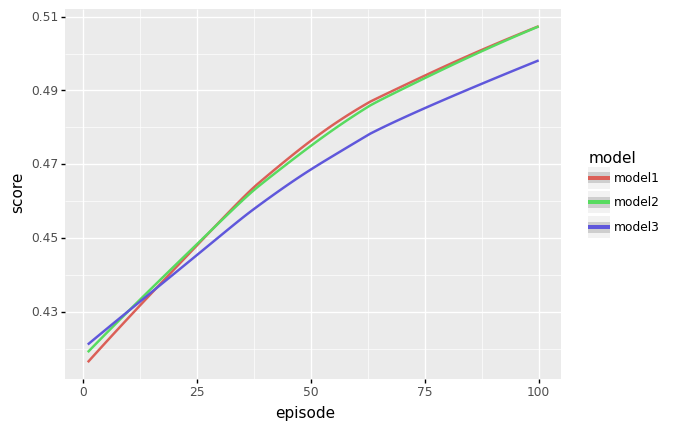

<ggplot: (8787581076438)>

In [99]:
pn.ggplot(df, pn.aes(x='episode', y='score', color='model')) + pn.geom_smooth()

## Value Model

This is the model where there is one Q network that takes in the states and outputs the value for the painting. The different Q values for left vs right painting are used to decide which painting to choose.

In [102]:
import value_agent
#from importlib import reload
#value_agent = reload(value_agent)
Agent2 = value_agent.Agent

In [108]:
def dqn(agent, n_episodes=100, eps_start=1.0, eps_end=0.1, eps_decay=0.98, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): The agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
    """
    scores = []                        # list containing scores from each episode
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, reward, done, info = env.reset(full_reset=False) # reset environment
        score = 0
        for t in range(env.n_trials - 1):
            pp_state = get_direct_state(info)
            action = agent.act(pp_state, eps)                         # select an action
            next_state, reward, done, info = env.step(action)      # send action to environment
            pp_next_state = get_direct_state(info)
            agent.step(pp_state, action, reward, pp_next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break
        mean_score = score/t # keep scores in range of 0-1, allow comparison to humans above
        scores.append(mean_score)            # save most recent score to total
        moving_avg = np.mean(scores)         # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
    return scores, moving_avg

In [110]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 32, 
    'gamma': 0.99, 
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-4, 
    'fc1_units': 32, 
    'fc2_units': 16, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent2(state_size=6, action_size=1, config_dict=config_dict)
scores, avgs = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.42
Episode 10	Average Score: 0.42
Episode 15	Average Score: 0.43
Episode 20	Average Score: 0.43
Episode 25	Average Score: 0.44
Episode 30	Average Score: 0.44
Episode 35	Average Score: 0.44
Episode 40	Average Score: 0.44
Episode 45	Average Score: 0.44
Episode 50	Average Score: 0.45
Episode 55	Average Score: 0.45
Episode 60	Average Score: 0.45
Episode 65	Average Score: 0.45
Episode 70	Average Score: 0.45
Episode 75	Average Score: 0.45
Episode 80	Average Score: 0.45
Episode 85	Average Score: 0.46
Episode 90	Average Score: 0.46
Episode 95	Average Score: 0.46
Episode 100	Average Score: 0.46


In [112]:
df = pd.DataFrame(dict(episode=np.arange(1, len(scores)+1), score=scores, moving_average=avgs))
df.head()

,episode,score,moving_average
0,1,0.425000,0.461
1,2,0.436364,0.461
2,3,0.395455,0.461
3,4,0.452273,0.461
4,5,0.400000,0.461


/Users/czarrar/Dropbox/ABD/Areas/Lab_Work/paint_cats/myenv_paintcats/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


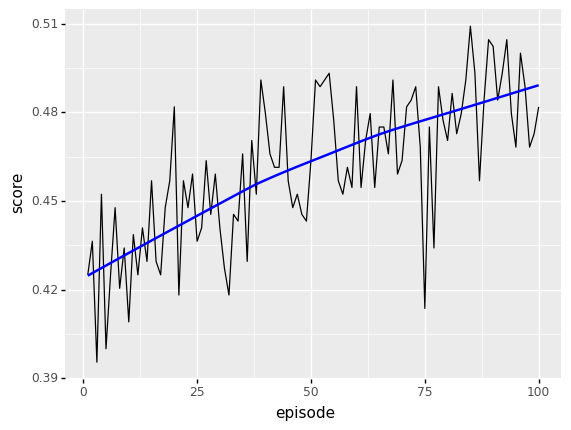

<ggplot: (8787582701291)>

In [113]:
pn.ggplot(df, pn.aes(x='episode', y='score')) + pn.geom_line() + pn.geom_smooth(color='blue')